## Load Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import dabest

import pandas as pd
import numpy as np
import scipy as sp

## Create dummy dataset

Here, we create a dummy dataset to illustrate how `dabest` functions.
In this dataset, each column corresponds to a group of observations, and each row is simply an index number referring to an observation. 

This is known as a 'wide' dataset. See this [writeup](https://sejdemyr.github.io/r-tutorials/basics/wide-and-long/) for more details.

In [2]:
dataset = list()
for seed in [10,11,12,13,14,15]:
    np.random.seed(seed) # fix the seed so we get the same numbers each time.
    dataset.append(np.random.randn(40))
df = pd.DataFrame(dataset).T
cols = ['Control','Group1','Group2','Group3','Group4','Group5']
df.columns = cols
# Create some upwards/downwards shifts.
df['Group2'] = df['Group2']-0.1
df['Group3'] = df['Group3']+0.2
df['Group4'] = (df['Group4']*1.1)+4
df['Group5'] = (df['Group5']*1.1)-1
# Add gender column.
df['Gender'] = np.concatenate([np.repeat('Male',20),
                              np.repeat('Female',20)])

Note that we have 6 groups of observations, with an additional non-numerical column indicating gender.

## The `bootstrap` class

Here, we introduce a new class called `bootstrap`. Essentially, it will compute the summary statistic and its associated confidence interval using bootstrapping. It can do this for a single group of observations, or for two groups of observations (both paired and unpaired).

Below, I obtain the bootstrapped contrast for 'Control' and 'Group1' in `df`.

In [3]:
contr = dabest.bootstrap(df['Control'],df['Group1'])

Calling our newly-declared object above will give a summary of the results.

In [4]:
contr

The unpaired mean difference is -0.1808044652703821.
[95.0 CI: -0.5985922697765205, 0.23978016228991592]

For more detailed results, you can access the `results` attribute, which returns a dictionary summarising the results of the contrast computation.

In [5]:
contr.results

{'bca_ci_high': 0.23978016228991592,
 'bca_ci_low': -0.59859226977652047,
 'ci': 95.0,
 'is_difference': True,
 'is_paired': False,
 'stat_summary': -0.1808044652703821}

`is_paired` indicates the two arrays are paired (or repeated) observations. This is indicated by the `paired` flag.

In [6]:
contr_paired = dabest.bootstrap(df['Control'],df['Group1'],
                                paired=True)
contr_paired

The paired mean difference is -0.18080446527038205.
[95.0 CI: -0.5869840085257696, 0.22675143755250823]

`is_difference` basically indicates if one or two arrays were passed to the `bootstrap` function. Obseve what happens if we just give one array.

In [7]:
just_control = dabest.bootstrap(df['Control'])
just_control

The mean is 0.1717562151007304.
[95.0 CI: -0.1266995114424271, 0.464182153196934]

Here, the confidence interval is with respect to the mean of the group `Control`.


There are several other statistics the `bootstrap` object contains. Please do have a look at its documentation. Below, I print the p-values for `contr_paired` as an example.


In [8]:
contr_paired.pvalue_2samp_paired_ttest

0.39310007728828344

In [9]:
contr_paired.pvalue_wilcoxon

0.35369319267722144

## Producing Plots

### Gardner-Altman independant two-group estimation plot

Below we produce three aligned Gardner-Altman floating estimation plots. 

The `plot` command will return 2 objects: a matplotlib `Figure` and a pandas `DataFrame`.
In the Jupyter Notebook, with `%matplotlib inline`, the figure should automatically appear.

`plot` will automatically drop any NaNs in the data. Note how the Ns (appended to the group names in the xtick labels) indicate the number of datapoints being plotted, and used to calculate the contrasts.

The pandas `DataFrame` returned by `plot` contains the pairwise comparisons made in the course of generating the plot, with confidence intervals (95% by default) and relevant p-values.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_ind_ttest,pvalue_mannWhitney
0,Control,Group1,-0.180804,-0.57833,0.233144,95.0,True,False,0.395987,0.363178


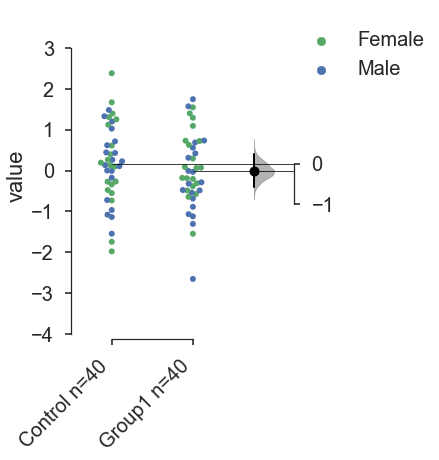

In [10]:
f, b = dabest.plot(df,
                      idx=('Control','Group1'),
                      color_col='Gender',
                      # Pass the length and width of the image, in inches.
                      fig_size=(4,6) 
                      )
b

### Gardner-Altman paired two-group estimation plot

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_paired_ttest,pvalue_wilcoxon
0,Control,Group2,-0.532006,-1.023143,-0.028848,95.0,True,True,0.04253,0.038456


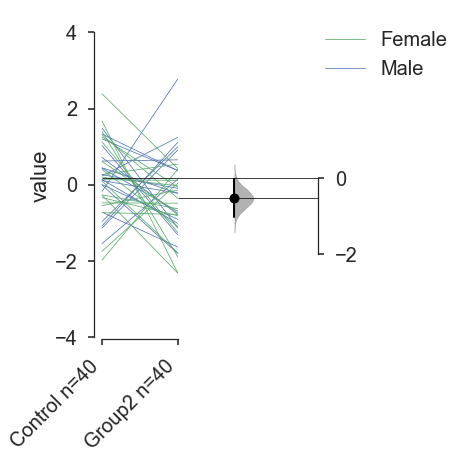

In [11]:
f, b = dabest.plot(df,
                   idx=('Control','Group2'),
                   color_col='Gender',
                   paired=True,
                   fig_size=(4,6))
b

If you want to plot the raw swarmplot instead of the paired lines, use the `show_pairs` flag to set this. The contrasts computed will still be paired, as indicated by the DataFrame produced.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_paired_ttest,pvalue_wilcoxon
0,Control,Group2,-0.532006,-1.015377,-0.042109,95.0,True,True,0.04253,0.038456


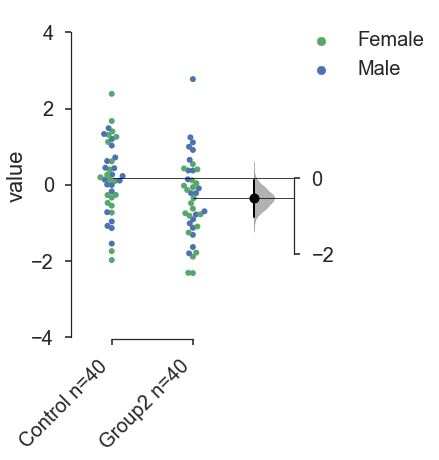

In [12]:
f, b = dabest.plot(df,
                  idx=('Control','Group2'),
                   color_col='Gender',
                   paired=True,
                   show_pairs=False,
                   fig_size=(4,6))
b

### Gardner-Altman multi-group estimation plot
In a multi-group design, you can horizontally tile two or more two-group floating-contrasts. This is designed to meet data visualization and presentation paradigms that are predominant in academic biomedical research.

This is done mainly through the `idx` option. You can indicate two or more tuples to create a seperate subplot for that contrast.

The effect sizes and confidence intervals for each two-group plot will be computed.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_ind_ttest,pvalue_mannWhitney
0,Control,Group1,-0.180804,-0.596996,0.233905,95.0,True,False,3.959867e-01,3.631777e-01
1,Group2,Group3,0.700802,0.282236,1.131210,95.0,True,False,2.720823e-03,2.555804e-03
2,Group4,Group5,-5.106777,-5.535896,-4.643635,95.0,True,False,7.985186e-35,1.435085e-14


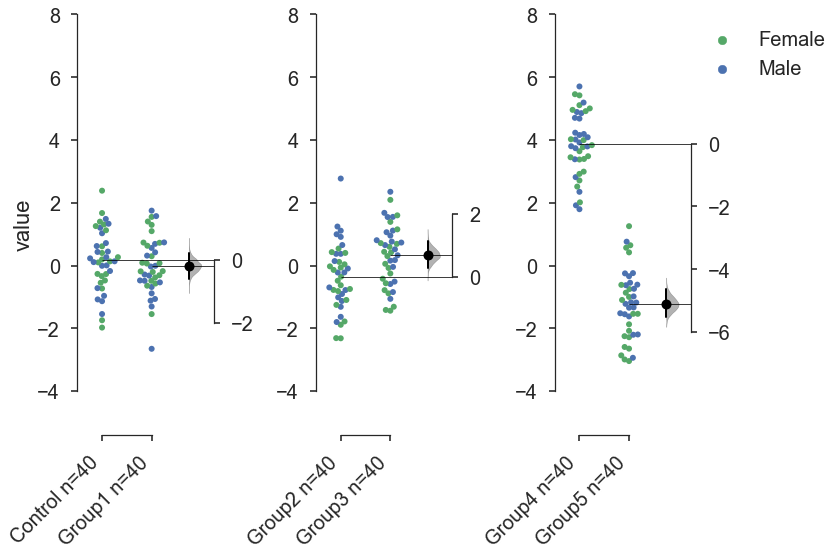

In [13]:
f, b = dabest.plot(df,
                   idx=(('Control','Group1'),
                        ('Group2','Group3'),
                        ('Group4','Group5')),
                   color_col='Gender')
b

### Cummings shared-control estimation plot
A common experimental design seen in contemporary biomedical research is a shared-control, or 'hub-and-spoke' design. Two or more experimental groups are compared to a common control group. 

A hub-and-spoke plot implements estimation statistics and aesthetics on such an experimental design.

If more than 2 columns/groups are indicated in a tuple passed to `idx`, then `dabest.plot` will produce a hub-and-spoke plot, where the first group in the tuple is considered the control group. The mean difference and confidence intervals of each subsequent group will be computed against the first control group.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_ind_ttest,pvalue_mannWhitney
0,Control,Group2,-0.532006,-0.950479,-0.098301,95.0,True,False,2.157452e-02,1.358049e-02
1,Control,Group4,3.709493,3.283089,4.140737,95.0,True,False,1.748492e-27,1.937605e-14


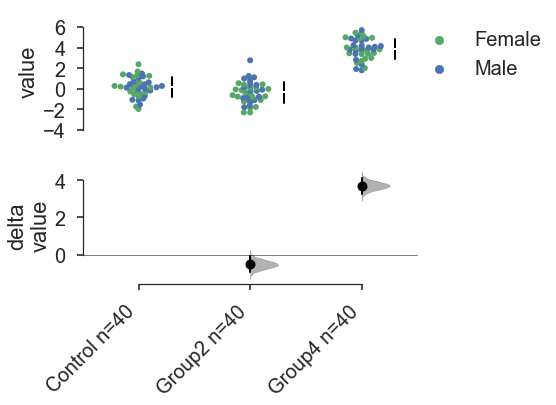

In [14]:
f, b = dabest.plot(df,
                   idx=('Control', 'Group2', 'Group4'),
                   fig_size=(6,5),
                   color_col='Gender')
b

In a Cumming plot, the bootstrapped effect size is shown on the lower panel for all comparisons. By default, a summary line is plotted for each group. The mean (indicated by the gap) and the standard deviation is plotted as a gapped line.

One can display the median with the 25th and 75th percentiles (a Tufte-style boxplot) using the `group_summaries` keyword argument in the function.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_ind_ttest,pvalue_mannWhitney
0,Control,Group2,-0.532006,-0.950534,-0.072861,95.0,True,False,2.157452e-02,1.358049e-02
1,Control,Group4,3.709493,3.289981,4.143509,95.0,True,False,1.748492e-27,1.937605e-14


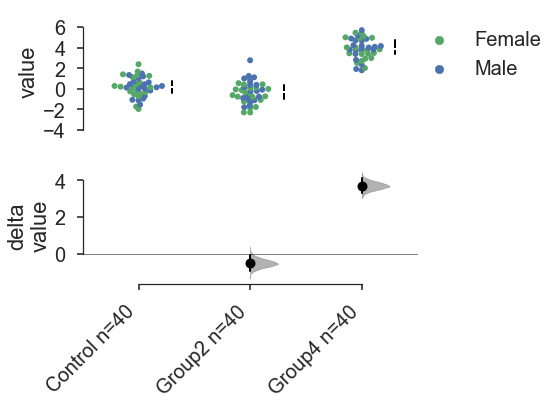

In [15]:
f, b = dabest.plot(df,
                   idx=('Control', 'Group2', 'Group4'),
                   fig_size=(6,5),
                   color_col='Gender',
                   group_summaries='median_quartiles')
b

## Controlling Aesthetics
Below we run through ways of customizing various aesthetic features.

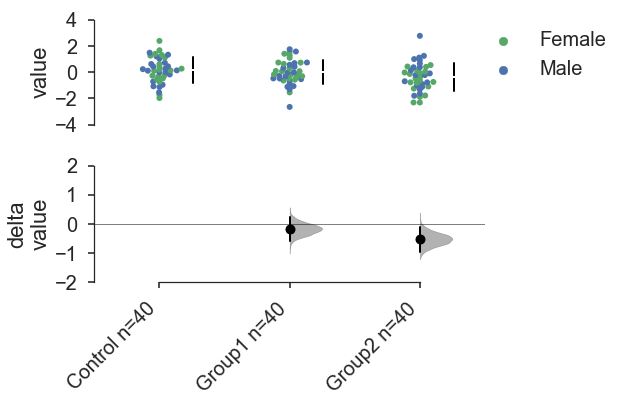

In [16]:
# Changing the contrast y-limits.
f, b = dabest.plot(df,
                   idx=('Control','Group1','Group2'),
                   color_col='Gender',
                   contrast_ylim=(-2,2))

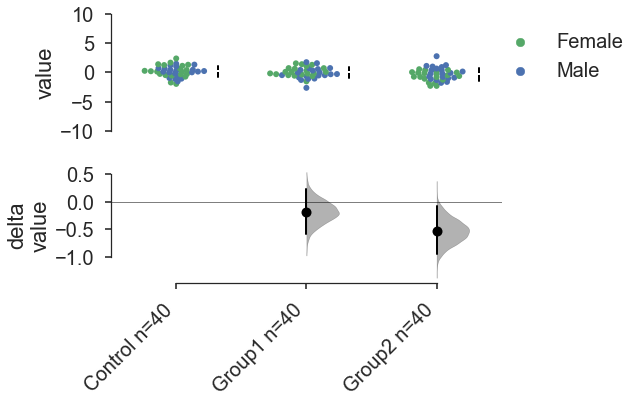

In [17]:
# Changing the swarmplot y-limits.
f, b = dabest.plot(df,
                    idx=('Control','Group1','Group2'),
                    color_col='Gender',
                    swarm_ylim=(-10,10))

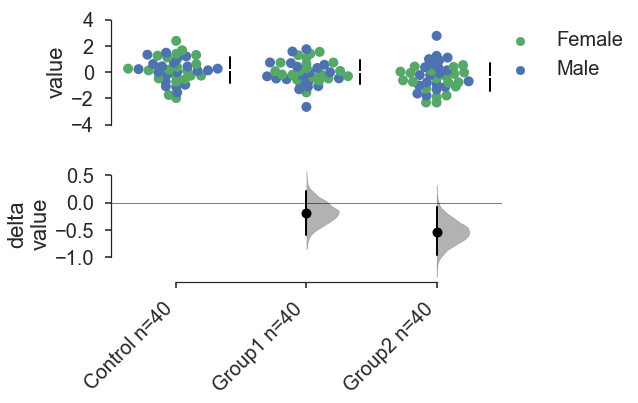

In [18]:
# Changing the size of the dots in the swarmplot.
# This is done through swarmplot_kwargs, which accepts a dictionary.
# You can pass any keywords that sns.swarmplot can accept.
f, b = dabest.plot(df,
                       idx=('Control','Group1','Group2'),
                       color_col='Gender',
                       swarmplot_kwargs={'size':10} 
                      )

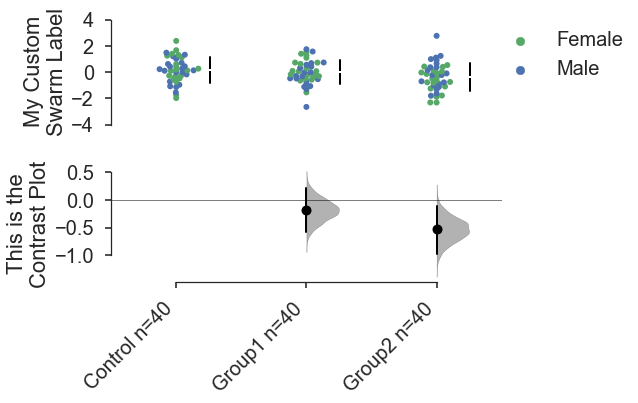

In [19]:
# Custom y-axis labels.
f, b = dabest.plot(df,
                   idx=('Control','Group1','Group2'),
                   color_col='Gender',
                   swarm_label='My Custom\nSwarm Label',
                   contrast_label='This is the\nContrast Plot'
                  )

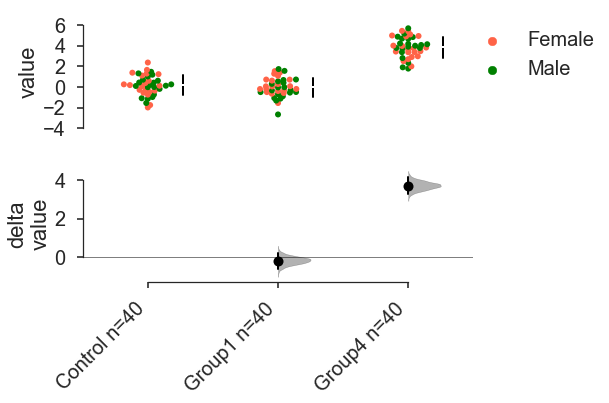

In [20]:
# Passing a list as a custom palette.
f, b = dabest.plot(df,
                   idx=('Control','Group1','Group4'),
                   color_col='Gender',
                   custom_palette=['green', 'tomato']
                  )

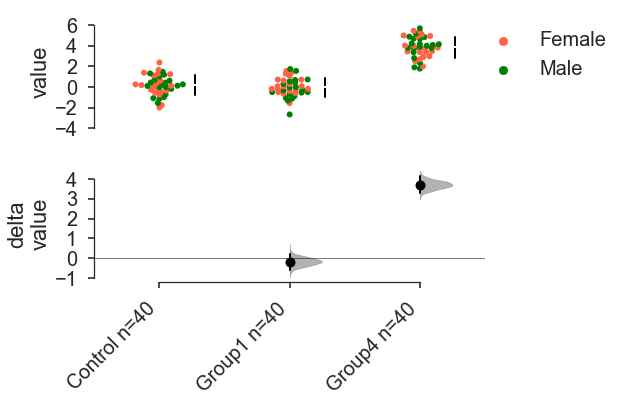

In [21]:
# Passing a dict as a custom palette.
f, b = dabest.plot(df,
                   idx=('Control','Group1','Group4'),
                   color_col='Gender',
                   custom_palette=dict(Male='green', Female='tomato')
                  )

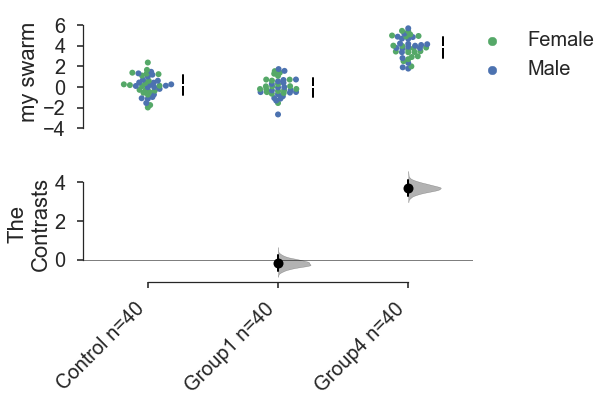

In [22]:
# custom y-axis labels for both swarmplots and violinplots.
f, b = dabest.plot(df,
                   idx=('Control','Group1','Group4'),
                   color_col='Gender',
                   swarm_label='my swarm',
                   contrast_label='The\nContrasts' # add line break.
                  )

## Appendix: On working with 'melted' DataFrames.

`dabest.plot` can also work with 'melted' or 'longform' data. This term is so used because each row will now correspond to a single datapoint, with one column carrying the value (`value`) and other columns carrying 'metadata' describing that datapoint (in this case, `group` and `Gender`).

For more details on wide vs long or 'melted' data, see https://en.wikipedia.org/wiki/Wide_and_narrow_data

To read more about melting a dataframe,see https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html

In [23]:
x='group'
y='my_metric'
color_col='Gender'

df_melt=pd.melt(df.reset_index(),
                id_vars=['index',color_col],
                value_vars=cols,value_name=y,var_name=x)

df_melt.head() # Gives the first five rows of `df_melt`.

,index,Gender,group,my_metric
0,0,Male,Control,1.331587
1,1,Male,Control,0.715279
2,2,Male,Control,-1.545400
3,3,Male,Control,-0.008384
4,4,Male,Control,0.621336


If you are using a melted DataFrame, you will need to specify the `x` (containing the categorical group names) and `y` (containing the numerical values for plotting) columns.

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_paired_ttest,pvalue_wilcoxon
0,Control,Group1,-0.180804,-0.565605,0.234559,95.0,True,True,0.3931,0.353693


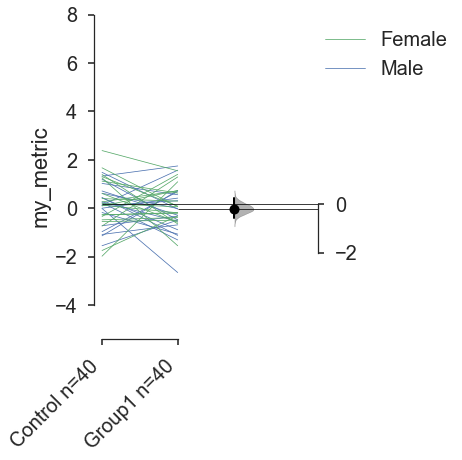

In [24]:
f, b = dabest.plot(df_melt,
                   x='group',
                   y='my_metric',
                   fig_size=(4,6),
                   idx=('Control','Group1'),
                   color_col='Gender',
                   paired=True
                  )
b